# Data Cleaning, EDA, and Modeling

## Imports

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, recall_score,
    precision_score, f1_score)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from bs4 import BeautifulSoup  
import wordcloud
from textblob import TextBlob
import regex as re
import warnings

In [42]:
subredditdata = pd.read_csv("../data/subredditdata.csv")

## Cleaning

In [44]:
subredditdata.head()

,title,selftext,subreddit,created_utc,name
0,POTG with some flair,NaN,Overwatch,1.706046e+09,t3_19dzvj0
1,Blizzard will be dropping the the argentine pe...,Things here are already insanely expensive as ...,Overwatch,1.706046e+09,t3_19dztr3
2,Do you think it would be possible to file a cl...,Not saying I will. I was just thinking about i...,Overwatch,1.706046e+09,t3_19dztdr
3,Widow goes Grrahhh,NaN,Overwatch,1.706045e+09,t3_19dzfr4
4,"Fly, fly, fly! 🪽",NaN,Overwatch,1.706045e+09,t3_19dz9f8


In [45]:
subredditdata.isnull().sum()

title            0
selftext       496
subreddit        0
created_utc      0
name             0
dtype: int64

In [46]:
subredditdata["selftext"].fillna("Media", inplace=True)

NaN values in the selftext category indicate that the title is the only text provided, but that it is likely accompanied by some sort of media like a photo or image that is relevant to the title. The presence of the NaN values in the selftext column could potentially still help indicate possible classifications. Due to the assumption being made, I replaced the NaN values with the string "Media" to indicate that there is an image or video present.

In [47]:
subredditdata.isnull().sum()

title          0
selftext       0
subreddit      0
created_utc    0
name           0
dtype: int64

In [48]:
subredditdata.head()

,title,selftext,subreddit,created_utc,name
0,POTG with some flair,Media,Overwatch,1.706046e+09,t3_19dzvj0
1,Blizzard will be dropping the the argentine pe...,Things here are already insanely expensive as ...,Overwatch,1.706046e+09,t3_19dztr3
2,Do you think it would be possible to file a cl...,Not saying I will. I was just thinking about i...,Overwatch,1.706046e+09,t3_19dztdr
3,Widow goes Grrahhh,Media,Overwatch,1.706045e+09,t3_19dzfr4
4,"Fly, fly, fly! 🪽",Media,Overwatch,1.706045e+09,t3_19dz9f8


In [49]:
subredditdata["overwatch"] = [1 if i == "Overwatch" else 0 for i in subredditdata["subreddit"]]

# This creates a feature "overwatch", which tells us that a post is from the Overwatch subreddit if the value is 1 or from the apexlegends subreddit if the value is 0

## EDA

In [50]:
X = subredditdata["selftext"]
y = subredditdata["overwatch"]

In [51]:
y.value_counts(normalize=True)

# This established what our baseline accuracy is for our model, indicating the ratio of Overwatch to non-Overwatch posts

overwatch
1    0.501018
0    0.498982
Name: proportion, dtype: float64

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=123)

In [57]:
cvec = CountVectorizer(stop_words="english")

In [58]:
X_train_cvec = cvec.fit_transform(X_train)

In [59]:
X_test_cvec = cvec.transform(X_test)

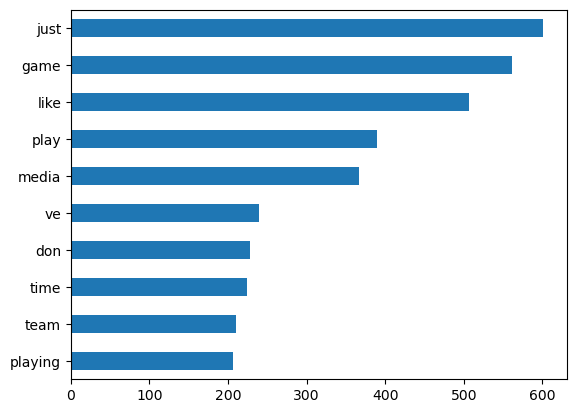

In [62]:
X_train_df = pd.DataFrame(X_train_cvec.todense(), 
                          columns=cvec.get_feature_names_out())

X_train_df.sum().sort_values().tail(10).plot(kind="barh");

Many of the top 10 most frequently occurring words in the dataset are common in gaming settings, or may be less common generic words. With further analysis, this should show that the less frequently occurring words help to distinguish the two subreddits.

## Modeling

In [168]:
scores = []

In [162]:
def evaluate(X_test, y_test, preds, model):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Reds')
    
    train = model.score(X_train, y_train)
    test = model.score(X_test, y_test)
    accuracy = accuracy_score(y_test, preds)

    print(f'Train: {train}')
    print(f'Test: {test}')
    print(f'Accuracy: {accuracy}')

    return {
        'Train': train,
        'Test': test,
        'Accuracy' : accuracy
    }

# Borrowed and adapted from Imbalanced Data lesson

### Model Selection

In [180]:
cveclrpipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(max_iter=1000))
])

In [179]:
tveclrpipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter=1000))
])

In [126]:
cvecmnbpipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [127]:
tvecmnbpipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [181]:
cveclrparams = {'cvec__max_features': [1000, 2000, 3000],
                'cvec__min_df': [0.02, 0.03, 0.05],
                'cvec__max_df': [0.85, 0.9, 0.95],
                'cvec__ngram_range': [(1,1), (1,2)],
                'cvec__stop_words': [None, "english"],
                'lr__penalty': ['l2'],
                'lr__C': [0.01, 0.1, 1, 10]
              }

In [182]:
tveclrparams = {'tvec__max_features': [1000, 2000, 3000],
                'tvec__min_df': [0.02, 0.05],
                'tvec__max_df': [0.85, 0.9, 0.95],
                'tvec__ngram_range': [(1,1), (1,2)],
                'tvec__stop_words': [None, "english"],
                'lr__penalty': ['l2'],
                'lr__C': [0.01, 0.1, 1, 10]
              }

In [128]:
cvecmnbparams = {'cvec__max_features': [1000, 2000, 3000],
                'cvec__min_df': [0.02, 0.03, 0.05],
                'cvec__max_df': [0.85, 0.9, 0.95],
                'cvec__ngram_range': [(1,1), (1,2)],
                'cvec__stop_words': [None, "english"],
              }

In [129]:
tvecmnbparams = {'tvec__max_features': [1000, 2000, 3000],
                'tvec__min_df': [0.02, 0.05],
                'tvec__max_df': [0.85, 0.9, 0.95],
                'tvec__ngram_range': [(1,1), (1,2)],
                'tvec__stop_words': [None, "english"]
                }

In [183]:
cveclrgs = GridSearchCV(cveclrpipe,
                  param_grid=cveclrparams,
                  cv=5,
                  verbose=1) 

In [184]:
tveclrgs = GridSearchCV(tveclrpipe,
                        param_grid=tveclrparams,
                        cv=5,
                        verbose=1)

In [130]:
cvecmnbgs = GridSearchCV(cvecmnbpipe,
                         param_grid=cvecmnbparams,
                         cv=5,
                         verbose=1)

In [131]:
tvecmnbgs = GridSearchCV(tvecmnbpipe, 
                         param_grid=tvecmnbparams,
                         cv=5,
                         verbose=1)

### Model Fitting

In [185]:
cveclrgs.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


In [186]:
cveclrgs.best_score_

0.6951919750951229

In [187]:
cveclrgs.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 1000,
 'cvec__min_df': 0.02,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'lr__C': 0.1,
 'lr__penalty': 'l2'}

In [188]:
cveclrgs_model = cveclrgs.best_estimator_

In [189]:
cveclrgs_model.score(X_train, y_train)

0.769857433808554

In [190]:
cveclrgs_model.score(X_test, y_test)

0.6293279022403259

In [191]:
cveclrgs_preds = cveclrgs_model.predict(X_test)

Train: 0.769857433808554
Test: 0.6293279022403259
Accuracy: 0.6293279022403259


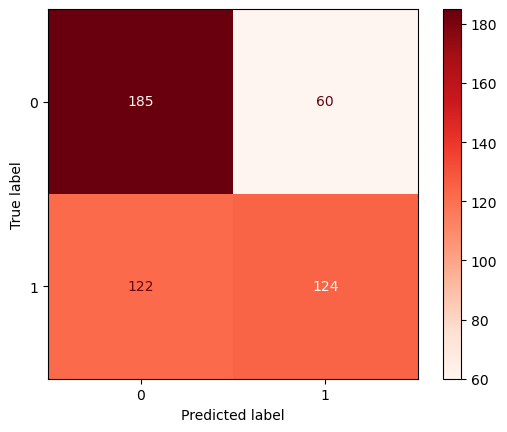

In [192]:
scores.append(evaluate(X_test, y_test, cveclrgs_preds, cveclrgs_model))

In [193]:
tveclrgs.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'lr__C': [0.01, 0.1, 1, 10], 'lr__penalty': ['l2'],
                         'tvec__max_df': [0.85, 0.9, 0.95],
                         'tvec__max_features': [1000, 2000, 3000],
                         'tvec__min_df': [0.02, 0.05],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=1)

In [116]:
tveclrgs.best_score_

0.7060371267150929

In [117]:
tveclrgs.best_params_

{'lr__C': 1,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.85,
 'tvec__max_features': 1000,
 'tvec__min_df': 0.02,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

In [118]:
tveclrgs_model = tveclrgs.best_estimator_

In [122]:
tveclrgs_model.score(X_train, y_train)

0.7671418873048201

In [121]:
tveclrgs_model.score(X_test, y_test)

0.6334012219959266

In [146]:
tveclrgs_preds = tveclrgs_model.predict(X_test)

Train: 0.7671418873048201
Test: 0.6334012219959266
Accuracy: 0.6334012219959266


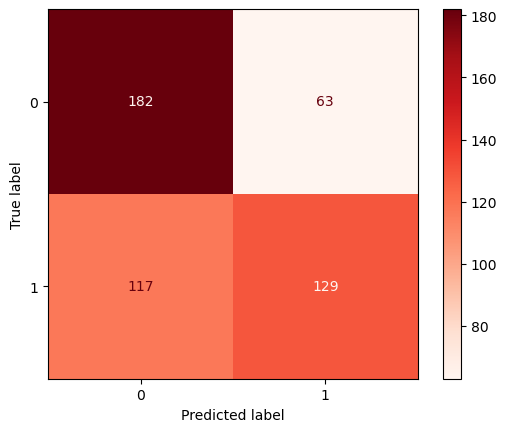

In [170]:
scores.append(evaluate(X_test, y_test, tveclrgs_preds, tveclrgs_model))

In [132]:
cvecmnbgs.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.85, 0.9, 0.95],
                         'cvec__max_features': [1000, 2000, 3000],
                         'cvec__min_df': [0.02, 0.03, 0.05],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english']},
             verbose=1)

In [133]:
cvecmnbgs.best_score_

0.7005949498443446

In [134]:
cvecmnbgs.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 1000,
 'cvec__min_df': 0.02,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

In [135]:
cvecmnbgs_model = cvecmnbgs.best_estimator_

In [136]:
cvecmnbgs_model.score(X_train, y_train)

0.7386286490156144

In [137]:
cvecmnbgs_model.score(X_test, y_test)

0.6578411405295316

In [147]:
cvecmnbgs_preds = cvecmnbgs_model.predict(X_test)

Train: 0.7386286490156144
Test: 0.6578411405295316
Accuracy: 0.6578411405295316


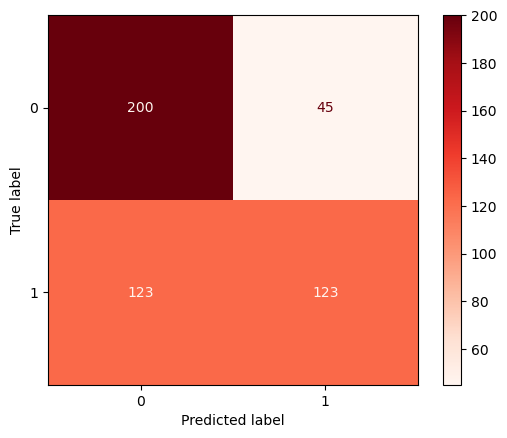

In [171]:
scores.append(evaluate(X_test, y_test, cvecmnbgs_preds, cvecmnbgs_model))

In [138]:
tvecmnbgs.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.85, 0.9, 0.95],
                         'tvec__max_features': [1000, 2000, 3000],
                         'tvec__min_df': [0.02, 0.05],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=1)

In [139]:
tvecmnbgs.best_score_

0.7012683039317421

In [140]:
tvecmnbgs.best_params_

{'tvec__max_df': 0.85,
 'tvec__max_features': 1000,
 'tvec__min_df': 0.02,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

In [141]:
tvecmnbgs_model = tvecmnbgs.best_estimator_

In [143]:
tvecmnbgs_model.score(X_train, y_train)

0.7528852681602173

In [144]:
tvecmnbgs_model.score(X_test, y_test)

0.6374745417515275

In [148]:
tvecmnbgs_preds = tvecmnbgs_model.predict(X_test)

Train: 0.7528852681602173
Test: 0.6374745417515275
Accuracy: 0.6374745417515275


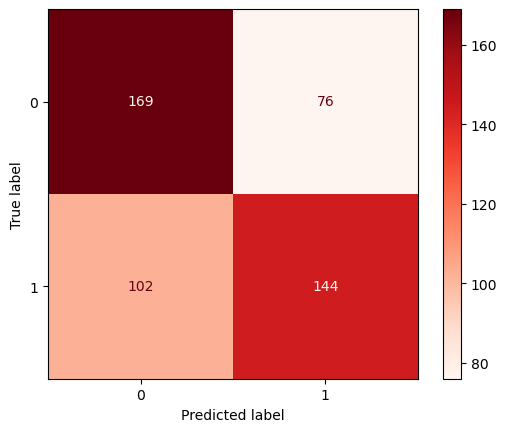

In [172]:
scores.append(evaluate(X_test, y_test, tvecmnbgs_preds, tvecmnbgs_model))

In [173]:
pd.DataFrame(scores, index = ['CVec LogReg', 'TVec LogReg', 
                             'CVec MultiNB', 'TVec MultiNB'])

,Train,Test,Accuracy
CVec LogReg,0.769857,0.629328,0.629328
TVec LogReg,0.767142,0.633401,0.633401
CVec MultiNB,0.738629,0.657841,0.657841
TVec MultiNB,0.752885,0.637475,0.637475


Based on the scores on the train and test data of all of the models, the Multinomial Naive Bayes using Count Vectorizer seems to be the most accurate while having the lowest rate of overfitting. This is the model that will be used for classifying posts.